## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot a one-minute ground track of all the Starlink satellites. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install cartopy matplotlib numpy pandas requests sgp4

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sgp4.api import Satrec

In [3]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

# Function to calculate the latitude, longitude and altitude        
def calculate_position(row):
    satrec = Satrec.twoline2rv(row['TLE_LINE1'], row['TLE_LINE2'])
    julianDate = row['JULIAN_DATE']

    getPos = lambda dSeconds: satrec.sgp4(julianDate + dSeconds / 86400, 0.0)[1]
    getLat = lambda position: np.degrees(np.arctan2(position[2], np.sqrt(position[0]**2 + position[1]**2)))
    getLon = lambda position: np.degrees(np.arctan2(position[1], position[0]))
    getAlt = lambda position: np.sqrt(position[0]**2 + position[1]**2 + position[2]**2) - 6371

    position = [getPos(dSeconds) for dSeconds in range(60)]
    lat = [getLat(position) for position in position]
    lon = [getLon(position) for position in position]
    alt = [getAlt(position) for position in position]

    return pd.Series([lat, lon, alt], index = ['LATITUDE', 'LONGITUDE', 'ALTITUDE'])

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = PAYLOAD
satPayload = "/class/gp/OBJECT_TYPE/PAYLOAD"

# Filters data by LAUNCH_DATE
predicate1  = "/LAUNCH_DATE/%3C%3Enull"

# Filters data by OBJECT_NAME
predicate2  = "/OBJECT_NAME/~~STARLINK"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

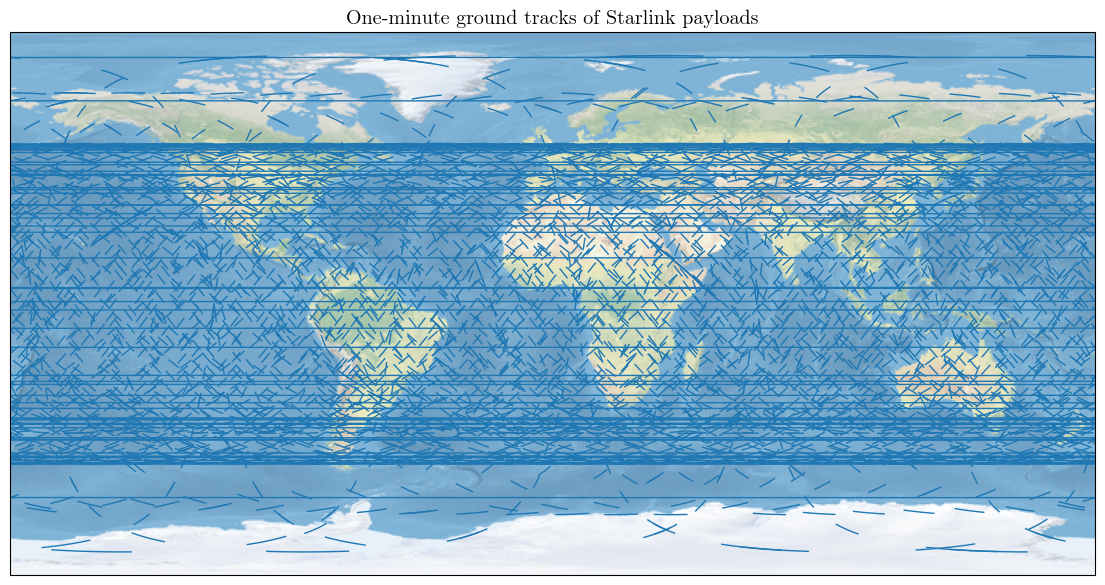

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')

    # Requests for PAYLOAD data where LAUNCH_DATE != null and OBJECT_NAME like STARLINK
    response1 = session.get(uriBase + requestQuery + satPayload + predicate1 + predicate2 
                            + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text

    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12

    dataFrame1['EPOCH'] = pd.to_datetime(dataFrame1['EPOCH'])

    # The fractional part of Julian date is omitted intentionally
    dataFrame1['JULIAN_DATE'] = dataFrame1['EPOCH'].apply(lambda x: int(x.to_julian_date())) 
    dataFrame1[['LATITUDE', 
                'LONGITUDE', 
                'ALTITUDE']] = dataFrame1.apply(lambda row: pd.Series(calculate_position(row)), 
                                                                         axis = 1)

    # Adjust the figure size accordingly
    fig, ax = plt.subplots(figsize = (14, 8), subplot_kw = {'projection': ccrs.PlateCarree()})
    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)

    # Plots the ground track of Starlink payloads
    # '#1f78b4' - is a shade of Lochmara
    plotPaths = lambda row: ax.plot(row['LONGITUDE'], row['LATITUDE'], 
                                      transform = ccrs.PlateCarree(), 
                                      color = '#1f78b4', linewidth = 1)
    dataFrame1.apply(plotPaths, axis = 1)
    ax.set_title("One-minute ground tracks of Starlink payloads")

session.close()